In [ ]:
import pandas as pd
df = pd.read_csv('/content/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.shape

(10811, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10811 entries, 0 to 10810
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           10811 non-null  object 
 1   Location       10811 non-null  object 
 2   MinTemp        10757 non-null  float64
 3   MaxTemp        10766 non-null  float64
 4   Rainfall       10676 non-null  float64
 5   Evaporation    4357 non-null   float64
 6   Sunshine       2005 non-null   float64
 7   WindGustDir    10624 non-null  object 
 8   WindGustSpeed  10624 non-null  float64
 9   WindDir9am     9786 non-null   object 
 10  WindDir3pm     10657 non-null  object 
 11  WindSpeed9am   10730 non-null  float64
 12  WindSpeed3pm   10734 non-null  float64
 13  Humidity9am    10616 non-null  float64
 14  Humidity3pm    10610 non-null  float64
 15  Pressure9am    10599 non-null  float64
 16  Pressure3pm    10595 non-null  float64
 17  Cloud9am       5655 non-null   float64
 18  Cloud3

In [ ]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)


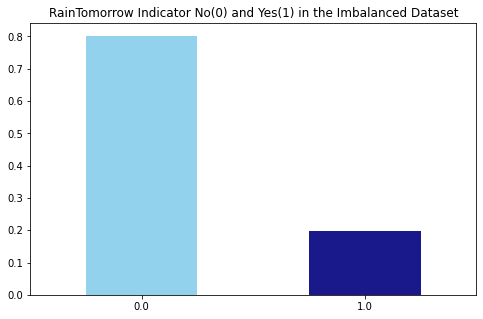

In [ ]:
import matplotlib.pyplot as plt    # to check if the dataset is unbalanced or balanced
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()


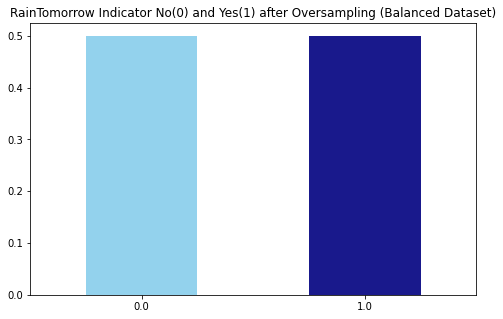

In [ ]:
from sklearn.utils import resample # Handling Class Imbalance For Rainfall Prediction

no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()


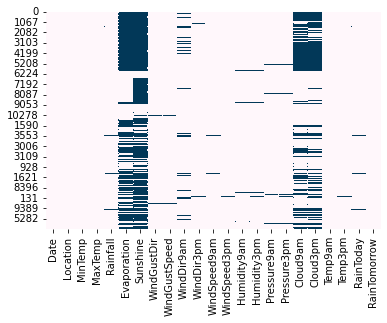

In [ ]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')


In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,13467,0.786900
Evaporation,10197,0.595828
Cloud9am,7380,0.431226
Cloud3pm,7072,0.413229


In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])


In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)


In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


Date             1429.000000
Location            2.000000
MinTemp             9.900000
MaxTemp             9.800000
Rainfall            2.091680
Evaporation         4.429948
Sunshine            6.415104
WindGustDir         8.000000
WindGustSpeed      16.000000
WindDir9am          8.000000
WindDir3pm          7.000000
WindSpeed9am       11.000000
WindSpeed3pm        9.000000
Humidity9am        29.000000
Humidity3pm        34.000000
Pressure9am         9.400000
Pressure3pm         9.300000
Cloud9am            4.000000
Cloud3pm            4.000000
Temp9am             8.897229
Temp3pm             9.400000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [ ]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape


(13130, 23)

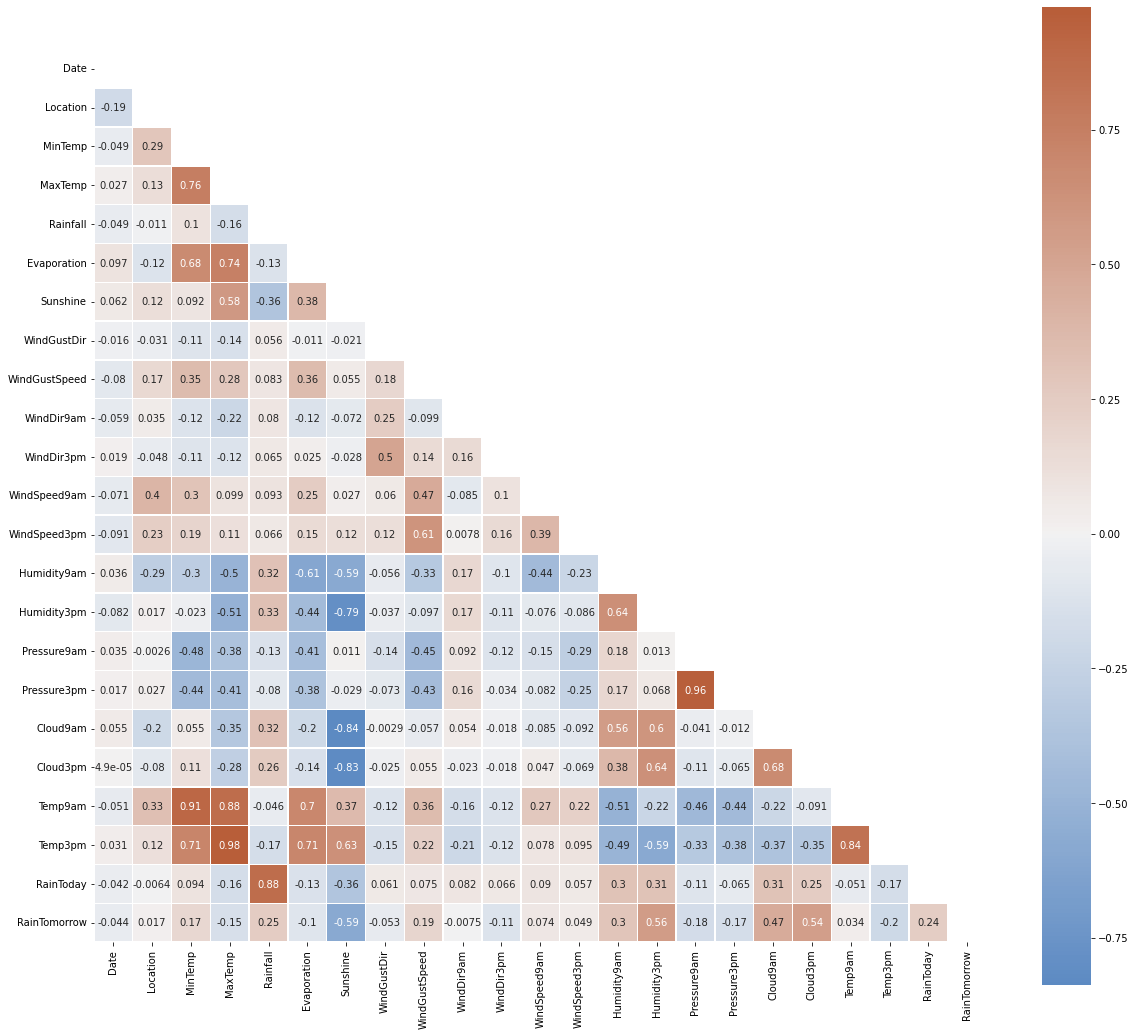

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})


In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])


Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'WindDir3pm', 'Humidity9am',
       'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)


['Sunshine', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']
[0.02955319 0.01420506 0.03417397 0.03219033 0.01937179 0.02976368
 0.14076205 0.02555965 0.04284907 0.01889085 0.03155609 0.01986234
 0.02407889 0.03704662 0.13069266 0.03639688 0.04299061 0.05986285
 0.15445825 0.03509124 0.03432746 0.0063165 ]


In [ ]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [ ]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')

    return model, accuracy, roc_auc, coh_kap, time_taken


Accuracy = 0.9153213524215656
ROC Area under Curve = 0.9192021076940934
Cohen's Kappa = 0.8297920670064333
Time taken = 0.14647269248962402
              precision    recall  f1-score   support

         0.0    0.95843   0.88774   0.92173      1844
         1.0    0.86857   0.95066   0.90776      1439

    accuracy                        0.91532      3283
   macro avg    0.91350   0.91920   0.91475      3283
weighted avg    0.91904   0.91532   0.91561      3283



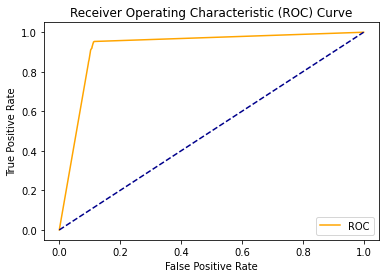

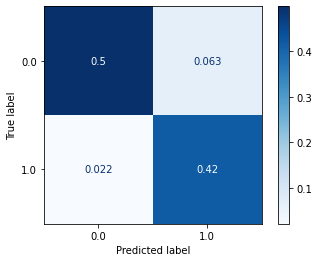

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

Accuracy = 0.9610112701797137
ROC Area under Curve = 0.9632323679224093
Cohen's Kappa = 0.9212621617904584
Time taken = 4.299570560455322
              precision    recall  f1-score   support

         0.0    0.98475   0.94523   0.96458      1844
         1.0    0.93325   0.98124   0.95664      1439

    accuracy                        0.96101      3283
   macro avg    0.95900   0.96323   0.96061      3283
weighted avg    0.96217   0.96101   0.96110      3283



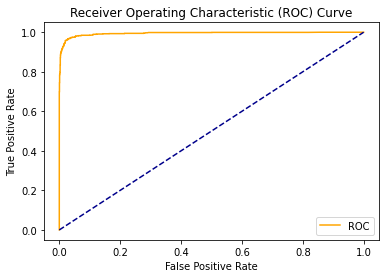

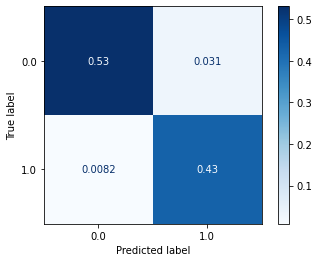

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

In [ ]:
# SVM
from sklearn import svm, datasets
import matplotlib.pyplot as plt

Accuracy = 0.8525738653670424
ROC Area under Curve = 0.8475483094882413
Cohen's Kappa = 0.6989369958195273
Time taken = 0.27020263671875
              precision    recall  f1-score   support

         0.0    0.85491   0.88829   0.87128      1844
         1.0    0.84931   0.80681   0.82751      1439

    accuracy                        0.85257      3283
   macro avg    0.85211   0.84755   0.84939      3283
weighted avg    0.85245   0.85257   0.85209      3283



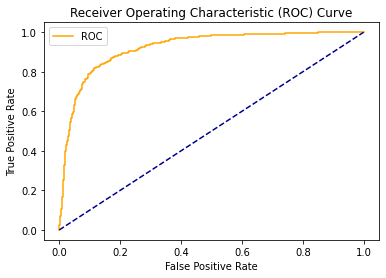

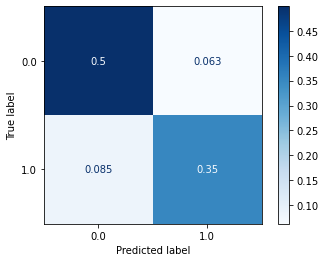

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)




In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

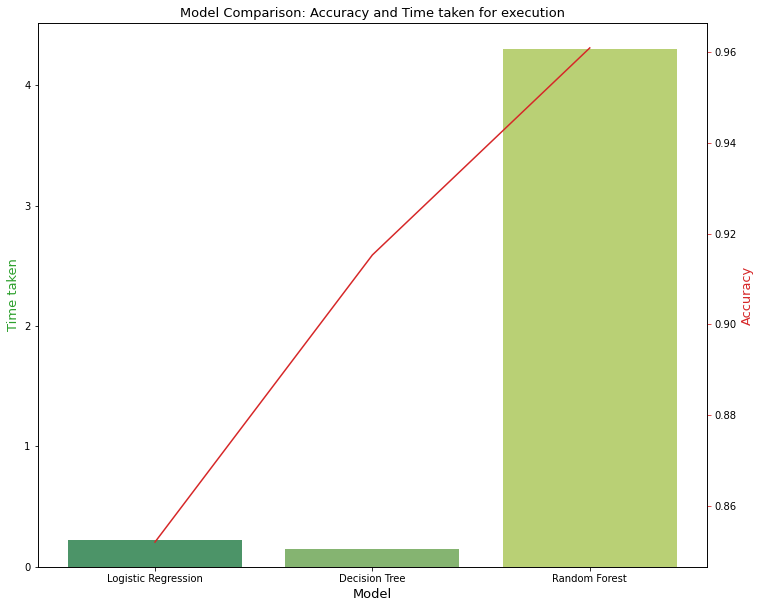

In [ ]:
accuracy_scores = [accuracy_lr, accuracy_dt,accuracy_rf]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf]
tt = [tt_lr, tt_dt, tt_rf]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)


In [ ]:
# Random forest algorithm has the higrest accuracy